# Counter Factual Explainer Basic with Higher Dimensional Datasets

In this tutorial, we show the use of the `CounterFactualExplainerBasic` in datasets with higher dimension. We show that there are some parameters that can be used to speed up the execution

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score

## Load Dataset

We will use the default credit card Dataset from the UCI machine learning repository. The dataset was used in [1]

In [4]:
path_dataset = "./data/credit/"
uci_credit = pd.read_csv(path_dataset + "UCI_Credit_card.csv")
uci_credit = uci_credit.drop(['ID', 'SEX', 'EDUCATION', 'MARRIAGE'], axis=1)

In [5]:
uci_credit.head()

,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,20000.0,24,2,2,-1,-1,-2,-2,3913.0,3102.0,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,120000.0,26,-1,2,0,0,0,2,2682.0,1725.0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,90000.0,34,0,0,0,0,0,0,29239.0,14027.0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,50000.0,37,0,0,0,0,0,0,46990.0,48233.0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,50000.0,57,-1,0,-1,0,0,0,8617.0,5670.0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


We keep only some features:

In [6]:
pay_feats = [c for c in uci_credit.columns if "PAY_" in c]
bill_feats = [c for c in uci_credit.columns if "BILL_" in c]
feats = ['LIMIT_BAL', 'AGE'] + pay_feats + bill_feats

label_col = "default.payment.next.month"

uci_credit = uci_credit[feats + [label_col]]

## Train Model

<b> Split </b>

Let's first split the dataset in train and test

In [7]:
df_train, df_test = train_test_split(uci_credit, test_size=0.2, random_state=34)

<b> Create Model and Train </b>

Now, we train a Random Forest Classifier:

In [8]:
model = RandomForestClassifier(
    n_estimators=50, max_depth=8, min_samples_split=4, min_samples_leaf=4, 
    class_weight='balanced', random_state=43
  )

model = model.fit(df_train[feats].values,  df_train[label_col].values)

## Evaluation

In [9]:
y_train_hat = model.predict(df_train[feats].values)
y_test_hat = model.predict(df_test[feats].values)

print(f'accuracy - Train: {accuracy_score(df_train[label_col].values, y_train_hat):.2f} '
      f'Test: {accuracy_score(df_test[label_col].values, y_test_hat):.2f}')

print(f'auc - Train: {roc_auc_score(df_train[label_col].values, y_train_hat):.2f} '
      f'Test: {roc_auc_score(df_test[label_col].values, y_test_hat):.2f}')

accuracy - Train: 0.80 Test: 0.78
auc - Train: 0.74 Test: 0.71


Let's obtain some samples where the prediction is True:

In [10]:
np.where(y_test_hat == 1)[0][0:10]

array([ 1,  5,  6, 10, 17, 18, 19, 28, 30, 36])

## CounterFactualExplainer

Now, let's try to use the `CounterFactualExplainerBasic` in order to obtain which features would need to be changed and how much in order to have a different prediction:

In [11]:
idx = 5
print(model.predict(df_test[feats].iloc[idx].values.reshape(1, -1)))
print(model.predict_proba(df_test[feats].iloc[idx].values.reshape(1, -1)))

[1]
[[0.19184036 0.80815964]]


In [12]:
from mercury.explainability import CounterFactualExplainerBasic

explainer = CounterFactualExplainerBasic(
    train=df_train[feats], 
    fn=model.predict_proba, 
    labels=list(df_train[feats].columns)
)

<b> Backtracking Strategy </b>

We will specify that the class 0 will need to reach a probability of 0.8. This means, that the probability of correct payment should reach 0.6 (now it's around 0.80)

In order to speed up the algorithm, we will specify three important parameters:
- `keep_explored_points`: We set it to False. This means that the algorithm won't keep which points are explored. This will save memory and will speed up the process.
- `limit`: This limits the amount of points explored in each iteration. The default is unlimitted, which can make the algorithm slower sometimes. In this case, we will set it to 50
- `max_iter`: This parameter sets the maximum iterations to perform. Sometimes, reaching the specified probability is a complicated task and might take too long. By setting the `max_iter` we set a maximum iterations to perform. If the algorithm reaches this number of iterations and still hasn't found a point with the specified probability, then it will return the point with the closest probability reached.

In [13]:
%%time
# backtrakcing strategy
explanation = explainer.explain(
    from_=df_test[feats].iloc[idx].values,
    strategy='backtracking',
    threshold=.8,
    class_idx=0,
    report=True,
    max_iter=500,
    keep_explored_points=False,
    limit=50
)

Iteration	Best Prob
177/500		0.81

CPU times: user 11.1 s, sys: 333 ms, total: 11.5 s
Wall time: 15.1 s


In [14]:
print('Found point with {} probability @ {}'.format(explanation.p, explanation.to_))

Found point with 0.8117853492342293 probability @ [ 1.0100000e+04  2.8520000e+01  5.5000000e-01 -1.9500000e+00
 -1.9500000e+00 -4.5000000e-01  0.0000000e+00  0.0000000e+00
  5.6927600e+03  3.5024180e+04  2.4010000e+04  7.0330000e+03
  2.8129500e+03  1.7050000e+03 -3.6058200e+03  3.5103800e+03
  4.7650295e+04  3.4866295e+04  2.0424000e+04  6.9833300e+03]


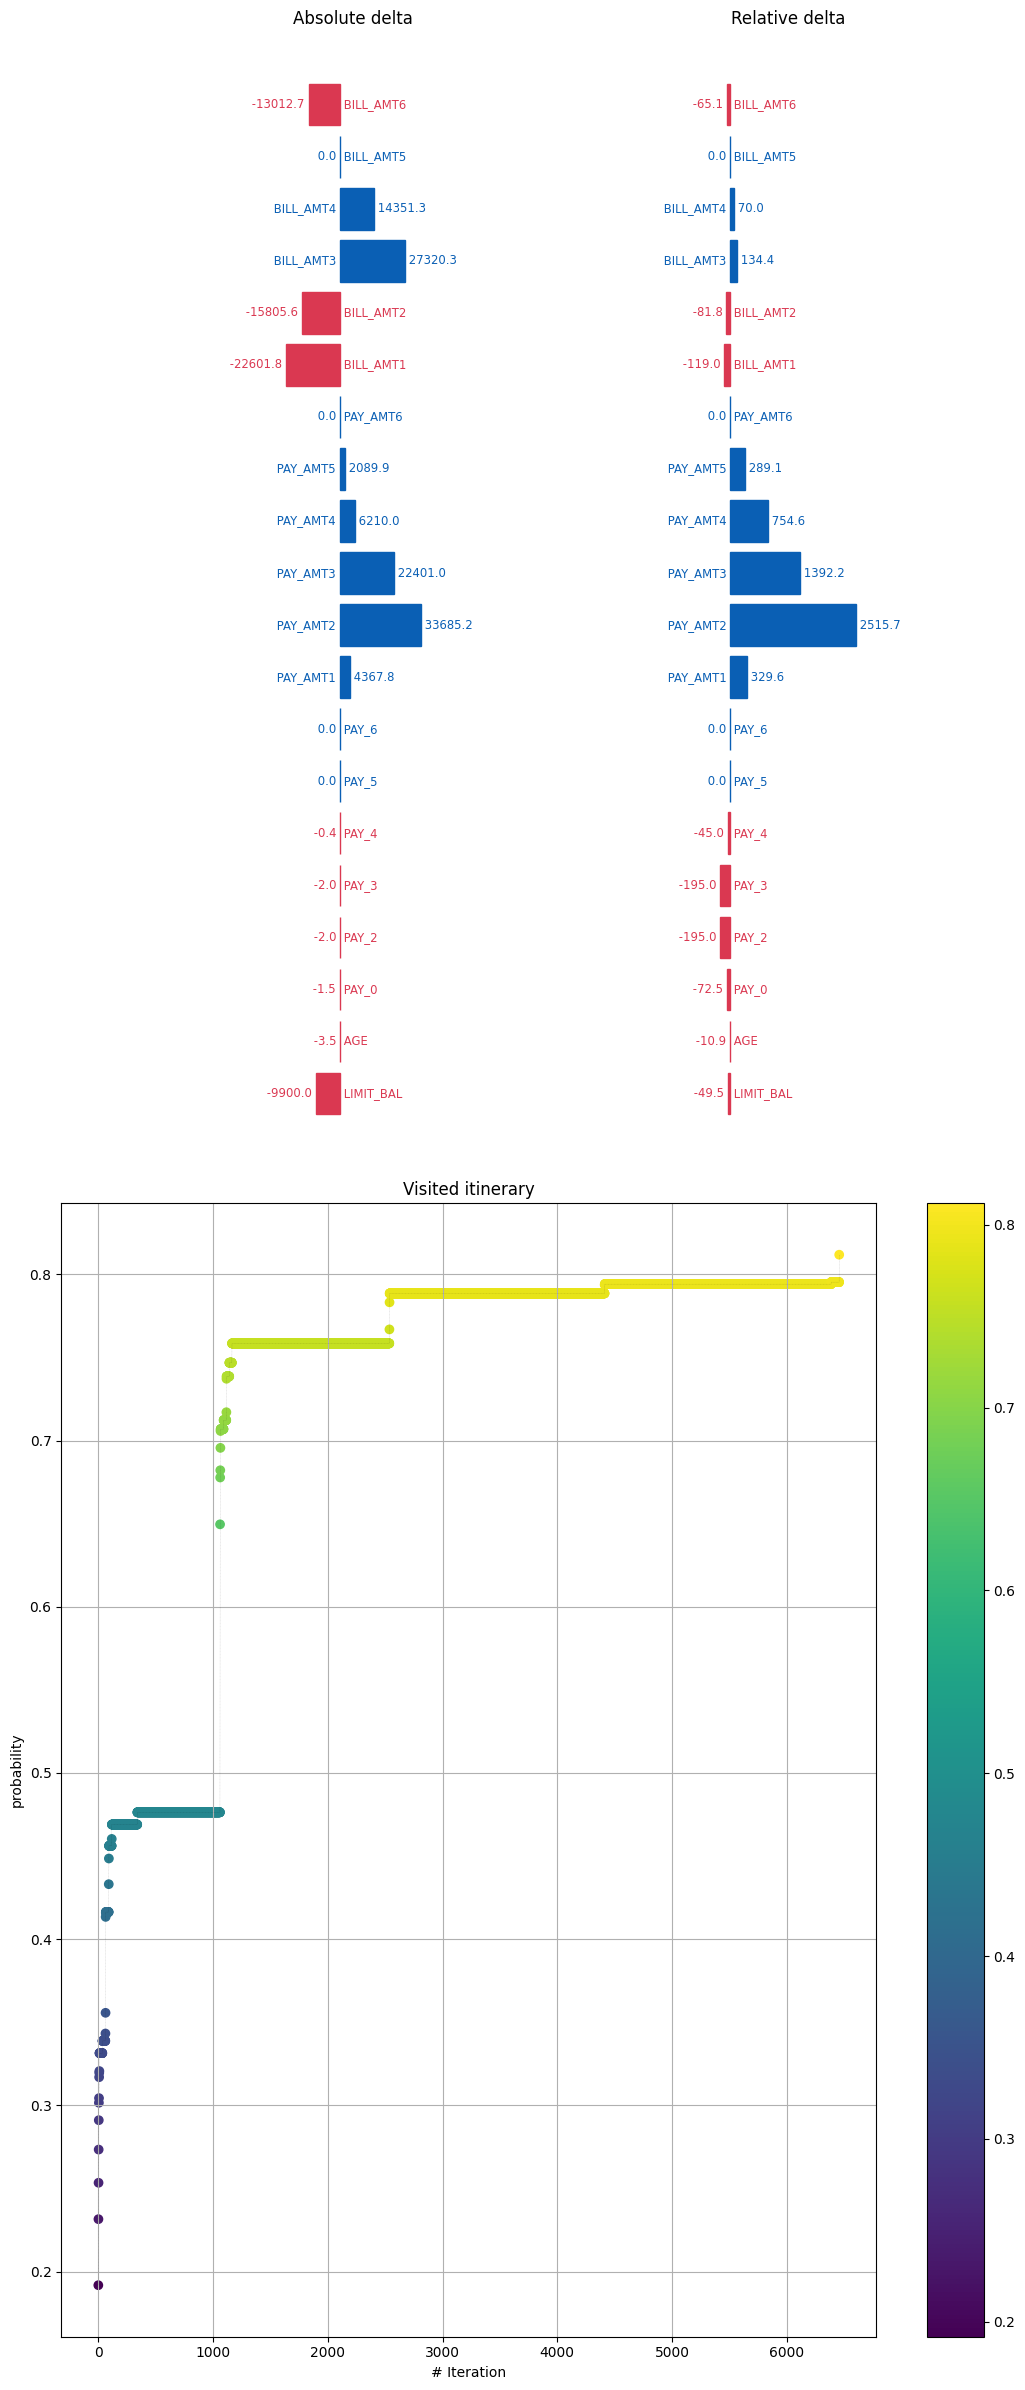

In [15]:
explanation.show(figsize=(11, 24))

<b> SimulatedAnnealing strategy </b>

An alternative to the backtracking strategy is the `SimulatedAnnealing` strategy. This might be useful in high dimensional spaces. Let's see how it works in this case:

In [16]:
%%time
# backtrakcing strategy
explanation = explainer.explain(
    from_=df_test[feats].iloc[idx].values,
    strategy='simanneal',
    threshold=.8,
    class_idx=0,
    report=True
)

 Temperature        Energy    Accept   Improve     Elapsed   Remaining


CPU times: user 4min 43s, sys: 16.6 s, total: 5min
Wall time: 4min 36s


In [17]:
print('Found point with {} probability @ {}'.format(explanation.p, explanation.to_))

Found point with 0.5595194969718815 probability @ [ 4.74533355e+04  3.21259040e+01  2.37952449e+00  3.61154092e-01
  1.06794640e-01 -4.82085213e-01 -4.29844073e-01  1.38769298e-01
  2.72221387e+04  1.16886958e+05  6.78307481e+04  3.01005655e+04
  2.91055244e+04  3.04350289e+04  1.79779008e+02 -4.92305518e+04
 -3.03424067e+03  1.98167950e+04  5.09469486e+04  5.78125335e+04]


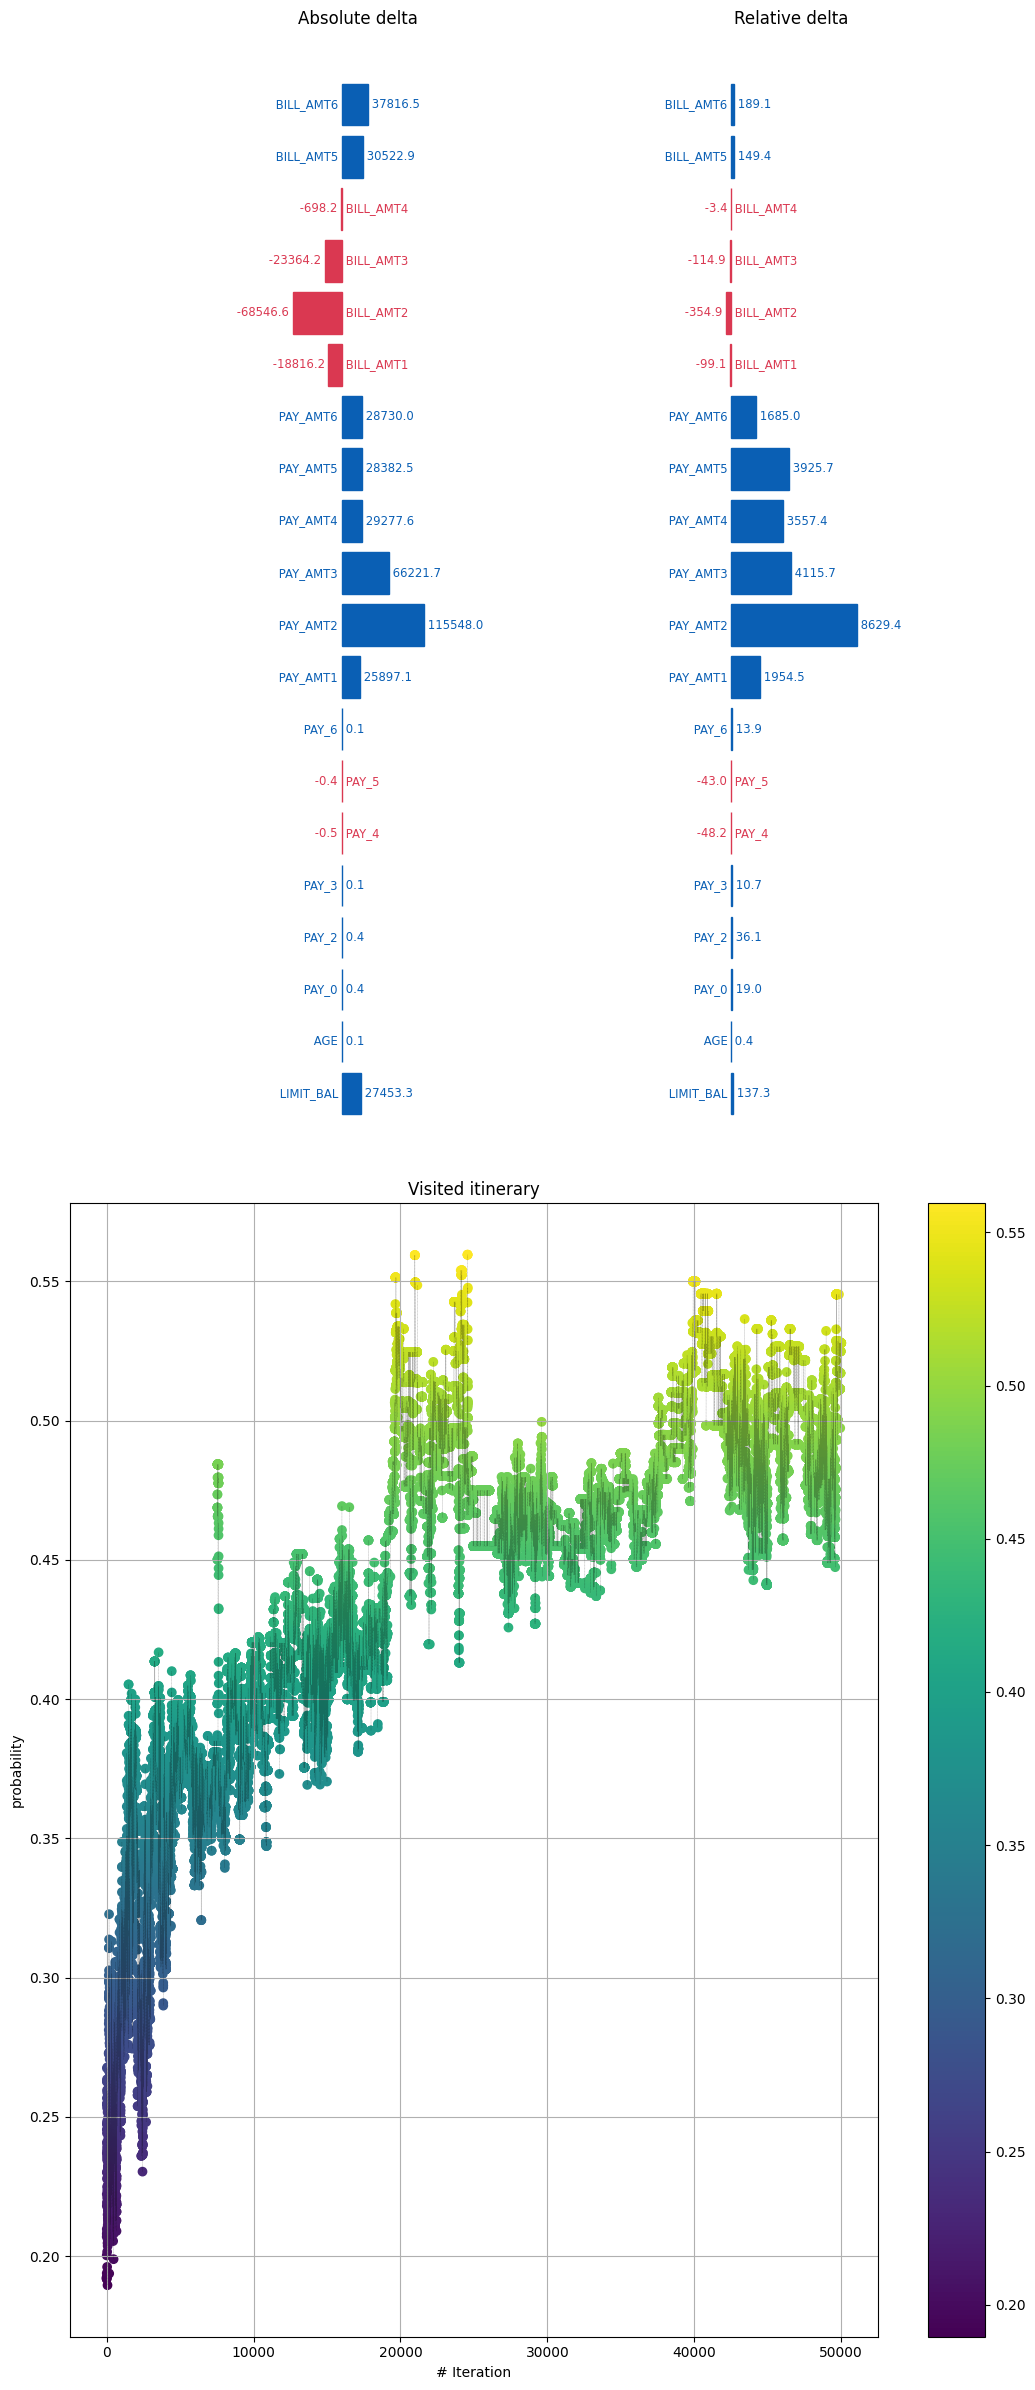

In [18]:
explanation.show(figsize=(11, 24))

In this case, the SimulatedAnneal took longer time

## References

[1] Yeh, I. C., & Lien, C. H. (2009). The comparisons of data mining techniques for the predictive accuracy of probability of default of credit card clients. Expert Systems with Applications, 36(2), 2473-2480. https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients